In [2]:
import numpy as np
import scipy as sp
from scipy.stats import norm
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm, sigmap, sigmam, Options)
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['lines.linewidth'] = 2

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1.5

In [4]:
ihbar = 0.1519267448e16 # Reciprocal reduced Planck's constant

tp1 = 800e-12 # Single-level pulse width (s)
tp2 = 340e-12 # Secondary pulse width in the case of multi-level pulse (s)
tm = 2e-9 # Measurement time (s)
#t_rise = 118e-12 # The pulse rise time given in the paper (unknown convention, assume from 20% to 80% of max value)
t_rise = 196.7e-12 # Estimated pulse rise time (0%-100%; if rise time, t_rise, is given using the 20%-80% convention, s)
#t_rise = 147.5e-12 # Estimated pulse rise time (0%-100%; if rise time, t_rise, is given using the 10%-90% convention, s)

eps_0 = -50e-6*ihbar/(2.0*np.pi)
eps_p = 100e-6*ihbar/(2.0*np.pi) # Control pulse maximum value/amplitude (Hz)
eps = 0 # Detuning, varies
dEL = 52.7e9 # Left singlet-triplet energy splitting (Hz)
dER = 9.2e9  # Right singlet-triplet energy splitting (Hz)
# Tunneling parameters (Hz)
d1 = 2.62e9 
d2 = 3.50e9
d3 = 4.60e9
d4 = 1.65e9

t_grid = np.linspace(0, 1.2, 1000) # ns

ket0 = basis(4, 0)
ket1 = basis(4, 1)
ket2 = basis(4, 2)
ket3 = basis(4, 3)

rho0 = ket0*ket0.dag()
H0 = Qobj([[0.5*eps, 0, d1, -d2],
           [0, 0.5*eps + dEL, -d3, d4],
           [d1, -d3, -0.5*eps, 0],
           [-d2, d4, 0, -0.5*eps + dER]])
HT = Qobj([[0.5, 0, 0, 0],
           [0, 0.5, 0, 0],
           [0, 0, -0.5, 0],
           [0, 0, 0, -0.5]])

pulse_x = np.cumsum([-t_rise, t_rise, t_rise, tp1 - t_rise, t_rise, t_rise])
pulse_y = [eps_0, eps_0, eps_p, eps_p, eps_0, eps_0]
# Use monotone cubic splines for the control pulses. This gives a smooth shape with 
# no overshoot and that closely matches the figures in the paper.
pulse = sp.interpolate.PchipInterpolator(pulse_x, pulse_y) 
pulse_t = pulse(t_grid*1e-9)
H = [H0*2.0*np.pi, [HT*2.0*np.pi, lambda t, args: pulse(t)]]

def eval_H(eps, dEL, dER, d1, d2, d3, d4):
    return Qobj([[0.5*eps, 0, d1, -d2],
                 [0, 0.5*eps + dEL, -d3, d4],
                 [d1, -d3, -0.5*eps, 0],
                 [-d2, d4, 0, -0.5*eps + dER]])*2.0*np.pi


## Energy levels

Text(0, 0.5, '$E\\; (\\mu$eV)')

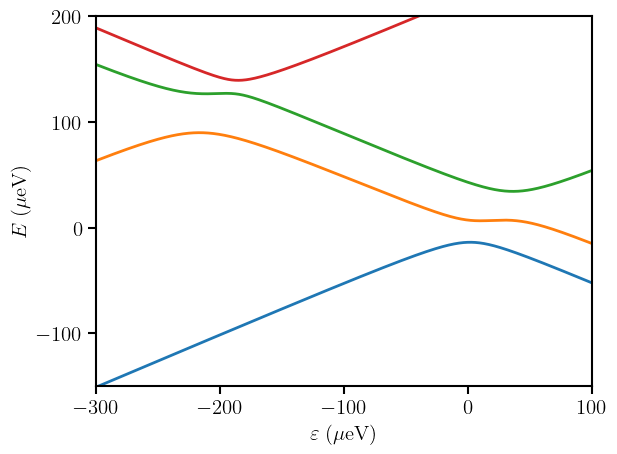

In [92]:
energies = np.empty((1000, 4))
eps_list = np.linspace(-300, 100, 1000)
for eidx, e in enumerate(eps_list):
    energies[eidx, :] = 1e6*eval_H(e*1e-6*ihbar/(2.0*np.pi), dEL, dER, d1, d2, d3, d4).eigenenergies()/ihbar

plt.plot(eps_list, energies[:, 0])
plt.plot(eps_list, energies[:, 1])
plt.plot(eps_list, energies[:, 2])
plt.plot(eps_list, energies[:, 3])
plt.xticks([-300, -200, -100, 0, 100])
plt.yticks([-100, 0, 100, 200])
plt.ylim([-150, 200])
plt.xlim([eps_list.min(), eps_list.max()])
plt.xlabel(r'$\varepsilon\; (\mu$eV)')
plt.ylabel(r'$E\; (\mu$eV)')

## Simple pulse

(0.0, 1.2)

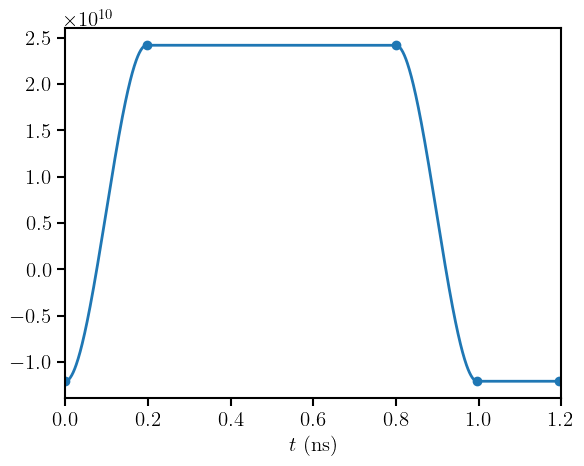

In [63]:
plt.plot(t_grid, pulse_t)
plt.xlabel('$t$ (ns)')
plt.scatter(pulse_x*1e9, pulse_y)
plt.xlim([0, 1.2])

### Density matrix

In [64]:
result = mesolve(H, rho0, t_grid*1e-9)

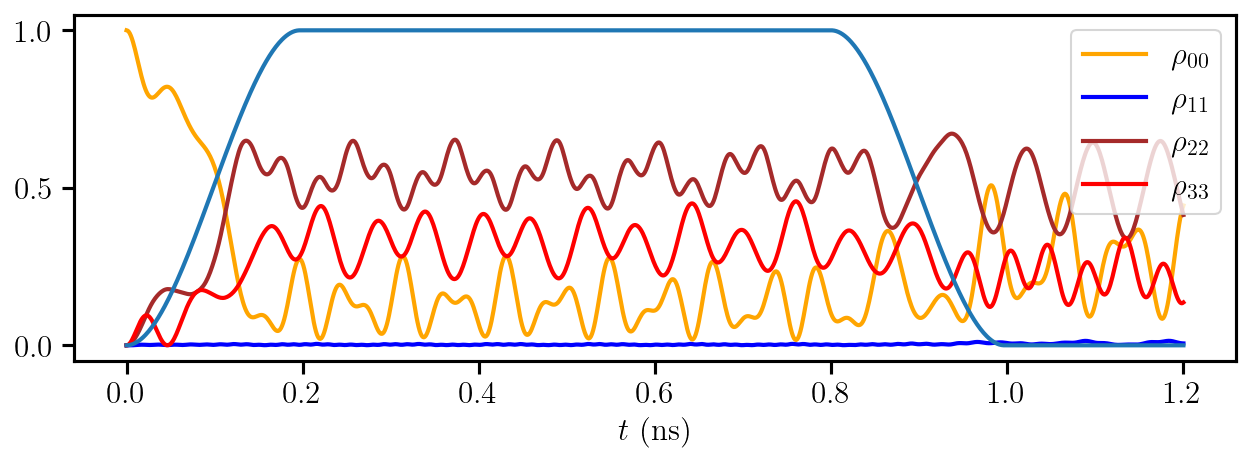

In [65]:
# Similar to Fig. 2 but not exactly the same, probably due to small differences in the control pulse (initial value, rise time, ...).

rho = np.array(result.states)

fig, ax = plt.subplots(figsize = (10, 3), dpi = 150)

ax.plot(t_grid, rho[:, 0, 0].real, label = r'$\rho_{00}$', color = 'orange')
ax.plot(t_grid, rho[:, 1, 1].real, label = r'$\rho_{11}$', color = 'blue')
ax.plot(t_grid, rho[:, 2, 2].real, label = r'$\rho_{22}$', color = 'brown')
ax.plot(t_grid, rho[:, 3, 3].real, label = r'$\rho_{33}$', color = 'red')

ax.plot(t_grid, (pulse_t - pulse_t.min())/(pulse_t.max() - pulse_t.min()))

ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('$t$ (ns)')
plt.legend()

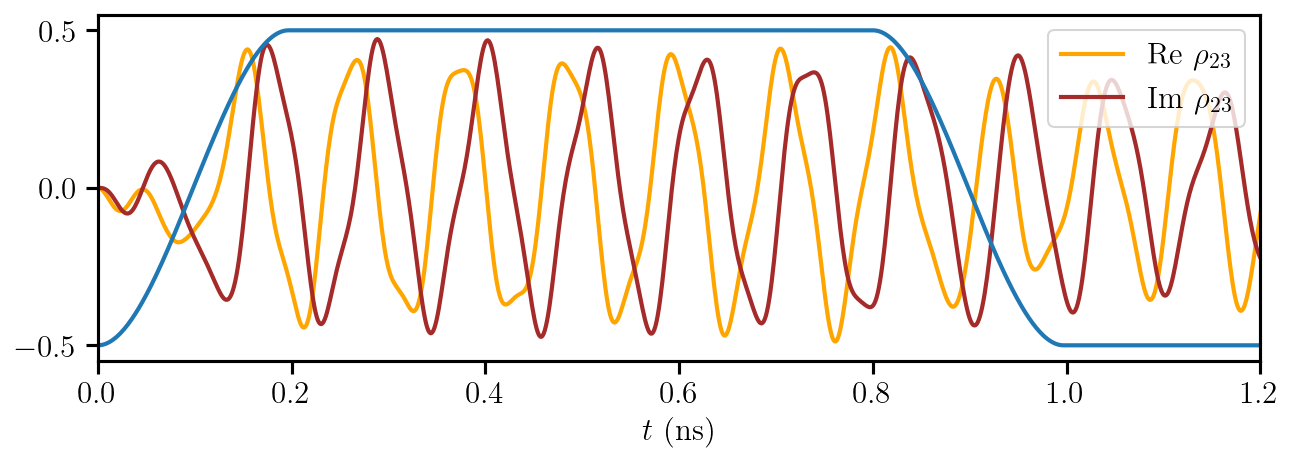

In [66]:
fig, ax = plt.subplots(figsize = (10, 3), dpi = 150)
ax.plot(t_grid, rho[:, 2, 3].real, label = r'Re $\rho_{23}$', color = 'orange')
ax.plot(t_grid, rho[:, 2, 3].imag, label = r'Im $\rho_{23}$', color = 'brown')
ax.plot(t_grid, (pulse_t - pulse_t.min())/(pulse_t.max() - pulse_t.min()) - 0.5)
ax.set_yticks([-0.5, 0, 0.5])
ax.set_xlabel('$t$ (ns)')
ax.set_xlim([0, 1.2])
plt.legend(loc = 'upper right')

### Charge state

In [680]:

e_ops = [ket0*ket0.dag() + ket1*ket1.dag(), ket2*ket2.dag() + ket3*ket3.dag()]
tp_count = 200 
eps_count = 200
tp_list = np.linspace(2*t_rise, 2.5e-9, tp_count+1)[1:]
eps_pad = 50
eps_list = np.linspace(-50-eps_pad, 100+eps_pad, eps_count) # µeV
results = np.empty((tp_count, eps_count, 2))

for tp_idx, tp in tqdm(enumerate(tp_list)):
    for eps_idx, eps_p in enumerate(eps_list):
        eps_p *= ihbar/(2.0*np.pi*1e6)        

        pulse_duration = t_rise + tp
        t_list = np.linspace(0, pulse_duration + 2e-9, 1000)
        cur_pulse = sp.interpolate.PchipInterpolator(np.cumsum([-t_rise, t_rise, t_rise, tp - t_rise, t_rise, t_rise]),
                                                     [eps_0, eps_0, eps_p, eps_p, eps_0, eps_0]) 
        H = [H0*2.0*np.pi, [HT*2.0*np.pi, lambda t, args: cur_pulse(t)]]

        cur_result = mesolve(H, rho0, t_list, e_ops = e_ops) 
        results[tp_idx, eps_idx, 0] = np.mean(cur_result.expect[0][t_list > pulse_duration])
        results[tp_idx, eps_idx, 1] = np.mean(cur_result.expect[1][t_list > pulse_duration])

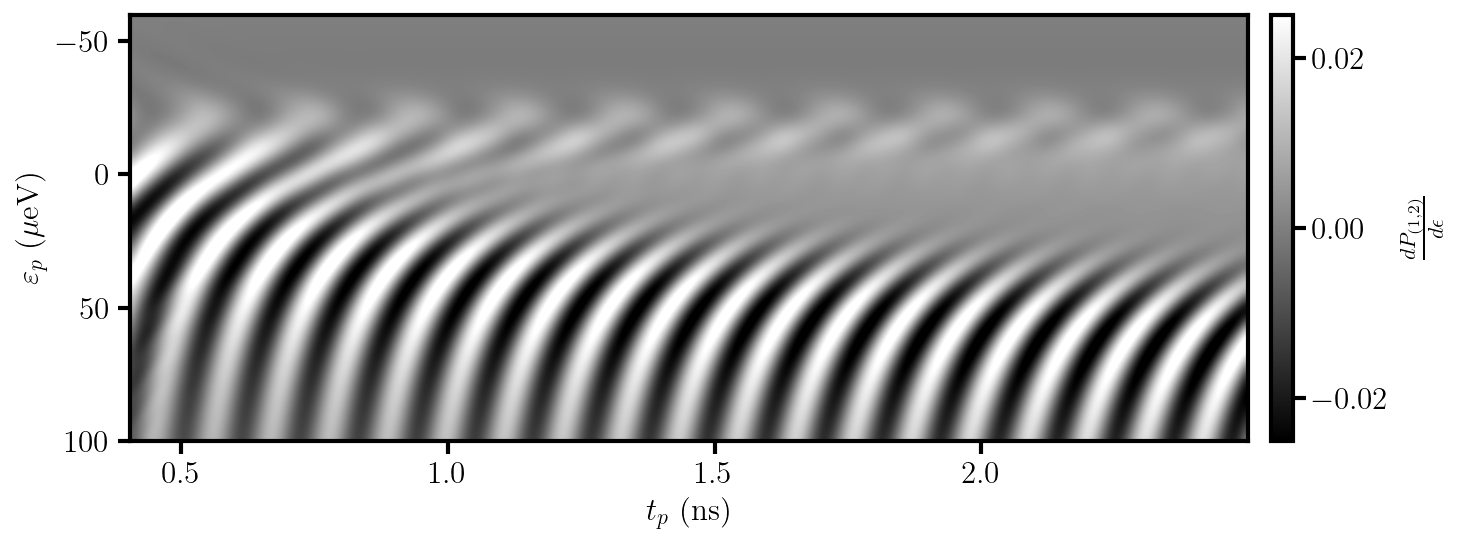

In [699]:
results_grad = np.gradient(results[:, :, 1], np.abs(eps_list[2] - eps_list[1]), axis = 1)
conv_offset_0 = np.argmin(np.abs(-60 - eps_list))
conv_offset_1 = np.argmin(np.abs(100 - eps_list))
convolved_results_grad = np.stack([np.convolve(results_grad[tp_idx, :], norm.pdf(eps_list, loc = 0, scale = 5), mode = 'same')
                                   for tp_idx in range(tp_count)])[:, conv_offset_0:conv_offset_1]

fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)
grad_im = ax.imshow(convolved_results_grad.T, 
                    cmap = 'gray',
                    aspect = 1/200,
                    interpolation = 'bicubic',
                    vmin = -0.025, vmax = 0.025,
                    extent = [tp_list.min()*1e9, tp_list.max()*1e9, eps_list[conv_offset_1], eps_list[conv_offset_0]],
                    origin = 'upper')
ax.set_xlabel('$t_p$ (ns)')
ax.set_ylabel(r'$\varepsilon_p\; (\mu$eV)')
ax.set_xticks([0.5, 1.0, 1.5, 2.0])
ax.set_yticks([-50, 0, 50, 100])

cbar = plt.colorbar(mappable = grad_im, label = r'$\frac{dP_{(1,2)}}{d\epsilon}$', fraction = 0.0183, pad = 0.02)
cbar.set_ticks([-0.02, 0, 0.02])

## Multilevel pulse

Text(0, 0.5, '$\\varepsilon$')

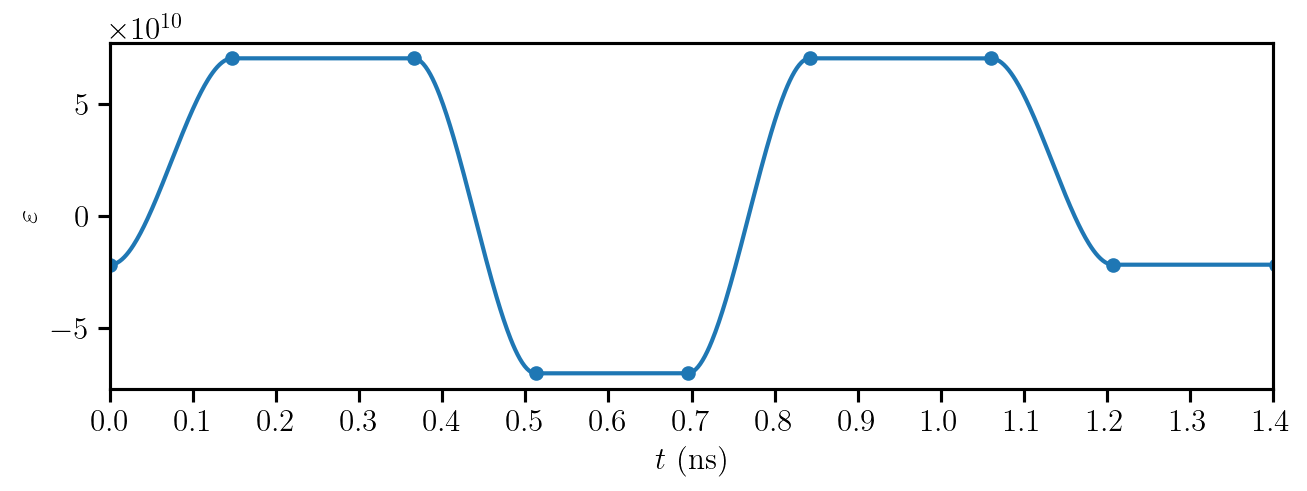

In [6]:
multi_eps_0 = -90e-6*ihbar/(2.0*np.pi)
multi_eps_p = 290e-6*ihbar/(2.0*np.pi)
multi_t_grid = np.linspace(0, 1.4, 1000)

multi_tp = 0.33e-9
multi_t_rise = 147e-12
ar = 0.5 + 0.5*(multi_eps_p - multi_eps_0)/(2*multi_eps_p)
multi_pulse_x = np.cumsum([-multi_t_rise, multi_t_rise, multi_t_rise, tp2-ar*multi_t_rise, multi_t_rise, multi_tp-multi_t_rise, multi_t_rise, tp2-ar*multi_t_rise, multi_t_rise, t_rise])
multi_pulse_y = [multi_eps_0, multi_eps_0, multi_eps_p, multi_eps_p, -multi_eps_p, -multi_eps_p, multi_eps_p, multi_eps_p, multi_eps_0, multi_eps_0]
multi_pulse = sp.interpolate.PchipInterpolator(multi_pulse_x, multi_pulse_y)

fig, ax = plt.subplots(figsize = (10, 3), dpi = 150)
ax.plot(multi_t_grid, multi_pulse(multi_t_grid*1e-9))
ax.scatter(multi_pulse_x*1e9, multi_pulse_y)
                          
ax.set_xticks(0.1*np.arange(15));
ax.set_xlim([0, 1.4])
ax.set_xlabel(r'$t$ (ns)')
ax.set_ylabel(r'$\varepsilon$')

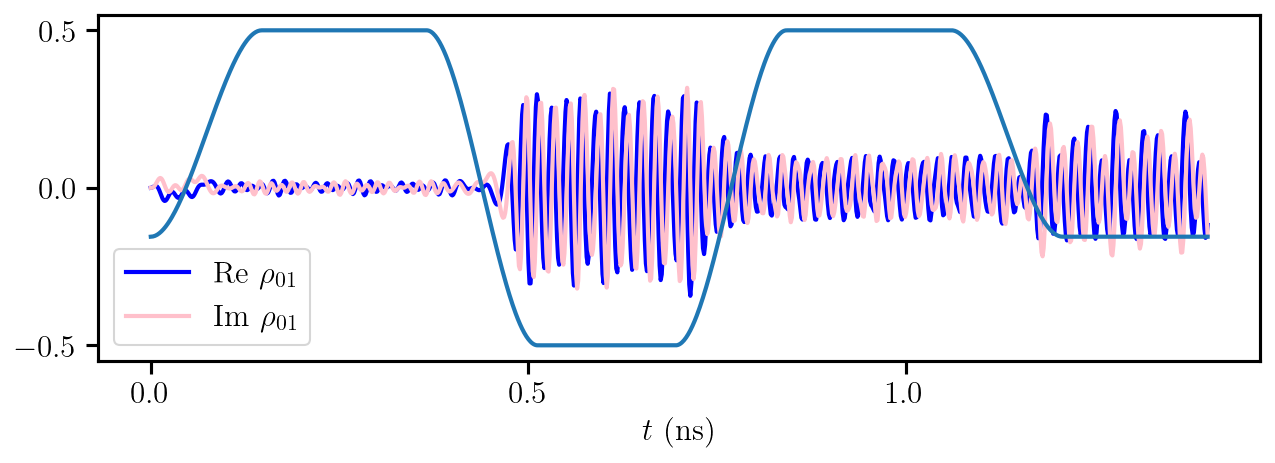

In [91]:
multi_H = [H0*(2.0*np.pi), [HT*(2.0*np.pi), lambda t, args: multi_pulse(t)]]
result = mesolve(multi_H, rho0, multi_t_grid*1e-9)
rho = np.array(result.states)

fig, ax = plt.subplots(figsize = (10, 3), dpi = 150)
ax.plot(multi_t_grid, rho[:, 0, 1].real, label = r'Re $\rho_{01}$', color = 'blue')
ax.plot(multi_t_grid, rho[:, 0, 1].imag, label = r'Im $\rho_{01}$', color = 'pink')

multi_pulse_t = multi_pulse(multi_t_grid*1e-9)
ax.plot(multi_t_grid, (multi_pulse_t - multi_pulse_t.min())/(multi_pulse_t.max() - multi_pulse_t.min()) - 0.5)
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.5, 0, 0.5])
ax.set_xlabel('$t$ (ns)')
plt.legend()